In [ ]:
import functools
import os
import numpy as np
import time
from absl import app
from absl import flags
from absl import logging

import mnist_model  # ADDED
# REMOVED from experimental.mimo import cifar_model  # local file import
import robustness_metrics as rm
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import baselines.utils_new as utils  # ADDED this!
# from uncertainty_baselines.baselines.cifar import utils
import uncertainty_metrics as um


import numpy as np
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

In [ ]:
ensemble_size = 1
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)



In [ ]:
def load_not_mnist(im_root,batch_size):
    dirs = os.listdir(im_root)
    label_dict = defaultdict()

    filenames=[]
    labels=[]
    for idx, dr in enumerate(dirs):
        # print(dr)
        label_dict[idx] = dr
        ims = os.listdir(os.path.join(im_root, dr))
        random.shuffle(ims)
        for im in (ims):
            if im=="RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png" or im== "Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png":
                continue
            # # 
            # image_string = tf.io.read_file(os.path.join(im_root, dr, im))
            # try:
            #     tf.io.decode_image(image_string)
            # except:
            #     print(im)
            #     continue
            else:
                filenames.append(os.path.join(im_root, dr, im))
                labels.append(idx)
        
    filenames = tf.constant(filenames)
    labels = tf.constant(labels) 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    def _parse_function(filename, label):

        normalize=True
        dtype = tf.float32

        image_string = tf.io.read_file(filename)
        image = tf.io.decode_image(image_string, dtype=dtype)

        # image = tf.image.convert_image_dtype(image_decoded, dtype)
        if normalize:
            # We use the convention of mean = np.mean(train_images, axis=(0,1,2))
            # and std = np.std(train_images, axis=(0,1,2)).
            mean = tf.constant([0.1307], dtype=dtype)
            std = tf.constant([0.3081], dtype=dtype)
            # Previously, std = np.mean(np.std(train_images, axis=(1, 2)), axis=0)
            # which gave std = tf.constant([0.2023, 0.1994, 0.2010], dtype=dtype).
            # However, we change convention to use the std over the entire training
            # set instead.
            image = (image - mean) / std
        label = tf.cast(label, dtype)
        return image, label

    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


In [ ]:
### LOAD DATASETS
test_datasets={}
test_batch_size=500
N_mnist = 10000
N_NOTmnist = 18710

dataset_builder_class = ub.datasets.MnistDataset
clean_test_dataset_builder = dataset_builder_class(split=tfds.Split.TEST)

clean_test_dataset = clean_test_dataset_builder.load(batch_size=test_batch_size)
test_datasets = {'clean': clean_test_dataset,}

load_c_dataset = utils.load_mnist_c

corruption_types, max_intensity = utils.load_corrupted_test_info("mnist")
for corruption in corruption_types[:]:
    for intensity in range(1, max_intensity + 1):
        dataset = load_c_dataset(
            corruption_name=corruption,
            corruption_intensity=intensity,
            batch_size=test_batch_size,
            use_bfloat16=False)

        test_datasets['{0}_{1}'.format(corruption, intensity)] = (
            # strategy.experimental_distribute_dataset(dataset))
            dataset)

not_minst_root = '/Users/benna/Desktop/DLA/dataset/notMNIST_small'
not_mnist_dataset= load_not_mnist(not_minst_root,test_batch_size)
test_datasets['notMNIST'] =  not_mnist_dataset

# acc=tf.keras.metrics.SparseCategoricalAccuracy()

#@tf.function
def test_step(test_iterator, dataset_name):
    if  dataset_name == 'clean':
        images, label = next(test_iterator).values()
    else:
        images, label = next(test_iterator)

    images = tf.tile(tf.expand_dims(images, 1), [1, ensemble_size, 1, 1, 1])
    logits = model(images, training=False)
    probs = tf.nn.softmax(logits)
    # print(probs.shape)
    probs = tf.math.reduce_mean(probs, axis=1)  # marginalize
    # acc.update_state(label, probs)
    # print(probs.shape)
    entr=entropy(probs,base=10,axis=1)
    # print(entr)
    # plt.hist(entr, histtype="step", align="left",bins=np.arange(-0.5,2.5,0.5))
    return entr


### TEST

ensemble_size = 1
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)

Entropies=defaultdict()

datasets_to_evaluate = test_datasets

for dataset_name, test_dataset in datasets_to_evaluate.items():
    entropy_test=[]
    test_iterator = iter(test_dataset)
    print('Testing on dataset %s', dataset_name)

    if dataset_name == "notMNIST":
        N_images = N_NOTmnist
    else:
        N_images = N_mnist
    entropy_test=[]
    for _ in range(N_images//test_batch_size):
        entropy_test.append(test_step(test_iterator, dataset_name))
    entropy_test = np.reshape(entropy_test, (-1,1))
    Entropies['M{0}_{1}'.format(ensemble_size, dataset_name)] = entropy_test

In [ ]:
ensemble_size = 2
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)

for dataset_name, test_dataset in datasets_to_evaluate.items():
    entropy_test=[]
    test_iterator = iter(test_dataset)
    print('Testing on dataset %s', dataset_name)

    if dataset_name == "notMNIST":
        N_images = N_NOTmnist
    else:
        N_images = N_mnist
    entropy_test=[]
    for _ in range(N_images//test_batch_size):
        entropy_test.append(test_step(test_iterator, dataset_name))
    entropy_test = np.reshape(entropy_test, (-1,1))
    Entropies['M{0}_{1}'.format(ensemble_size, dataset_name)] = entropy_test

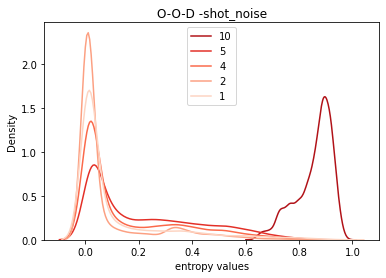

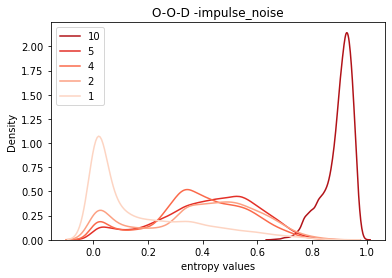

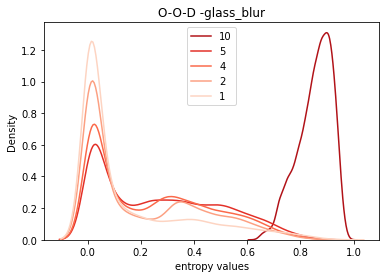

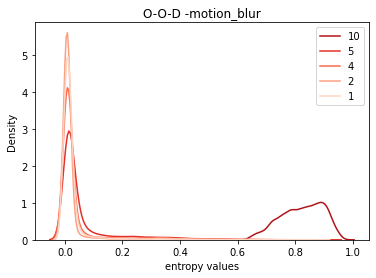

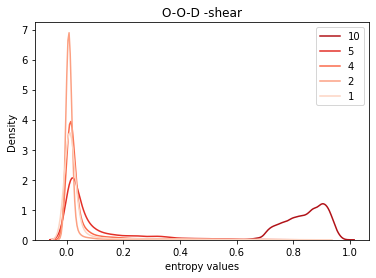

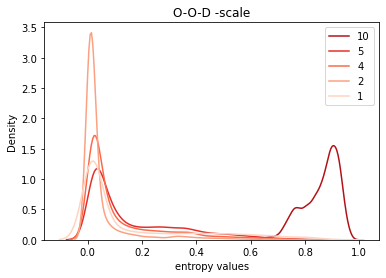

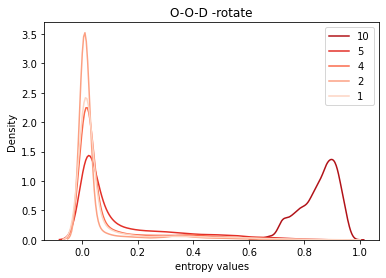

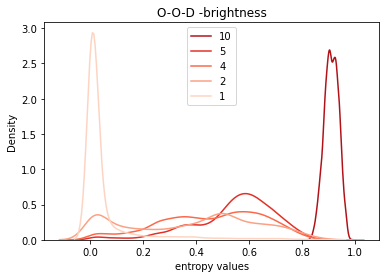

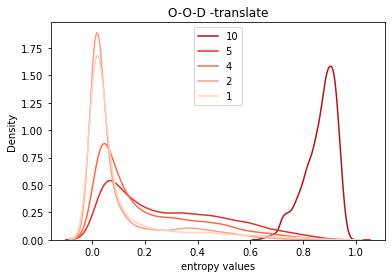

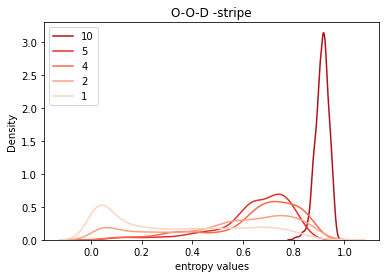

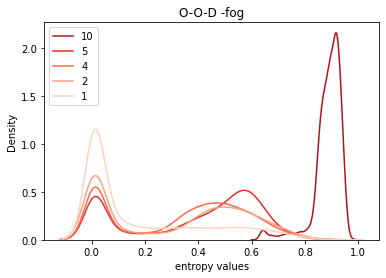

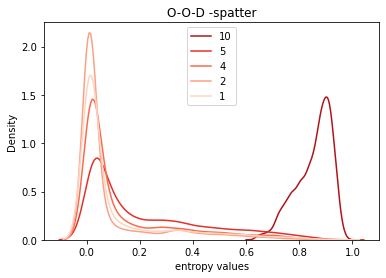

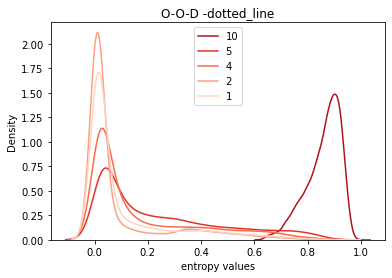

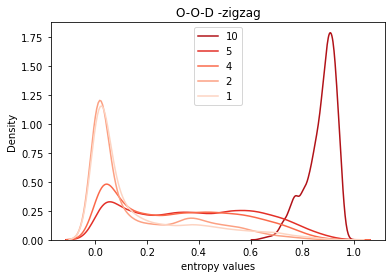

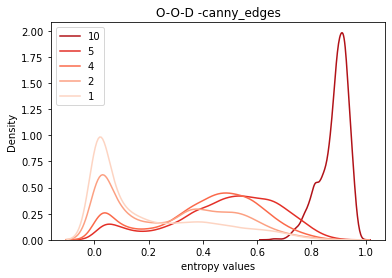

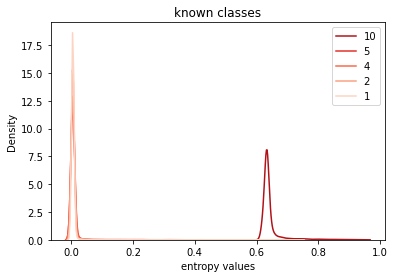

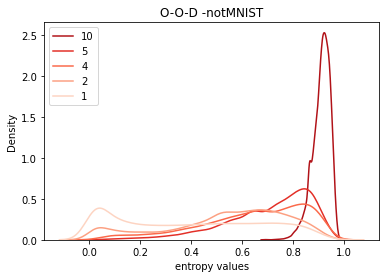

In [146]:
import pickle as pkl
import numpy as np

M=[1, 2, 4, 5, 10]
N_mnist = 10000
N_NOTmnist = 18500


corruption_types, max_intensity = utils.load_corrupted_test_info("mnist")
corruption_types = [c+'_'+str(max_intensity)for c in corruption_types]
corruption_types.append("clean")
# corruption_types.extend(["notMNIST", "clean"])
# corruption_types
E={}
for c in corruption_types:
    E[c]= np.zeros((len(M),N_mnist))
E["notMNIST"] = np.zeros((len(M),N_NOTmnist))

for i,ensemble_size in enumerate(M):#np.append(np.arange (1,7), 10):
    Entropies = pkl.load( open( "Entropies_M"+str(ensemble_size)+".pkl", "rb" ) )
    for dataset_name, entr in Entropies.items():
        # print(dataset_name)
        name=dataset_name[4:] if ensemble_size ==10 else  dataset_name[3:]
        E[name][i]=entr.flatten()
        # print(dataset_name[3:])
        # print(name)
for dataset_name, entr in E.items():
    if dataset_name!= "identity_1":
        name = dataset_name if dataset_name== "clean" or dataset_name == 'notMNIST' else dataset_name[:-2]
        title= "O-O-D -" + name if name != "clean" else "known classes"
        plt.figure()
        sns.kdeplot(data=E[dataset_name].T, palette="Reds")
        plt.legend(np.flip(M))
        plt.xlabel("entropy values")
        plt.title(title)
        plt.plot()
        plt.savefig(title+'.png', dpi=1000)
    

#         if dataset_name == 'M'+str(ensemble_size)+'':
# for i in range(len(M)):
    # sns.kdeplot(data=E["clean"][i])
    # (E["clean"][i], hist=False, kde=True, bins=np.arange(0,2,1), color = 'red', kde_kws={'linewidth': 1 })
# sns.kdeplot(data=E["clean"][:2,:100])


# plt.plot()



In [15]:
import functools
import os
import numpy as np
import time
from absl import app
from absl import flags
from absl import logging

import mnist_model  # ADDED
# REMOVED from experimental.mimo import cifar_model  # local file import
import robustness_metrics as rm
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import baselines.utils_new as utils  # ADDED this!
# from uncertainty_baselines.baselines.cifar import utils
import uncertainty_metrics as um


import numpy as np
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
import pickle as pkl


# import argparse

# parser = argparse.ArgumentParser()

# parser.add_argument("--ensemble", help="ensemble size.", default=1,type=int)

# args = parser.parse_args()
# ensemble_size = args.ensemble
ensemble_size=3

def load_not_mnist(im_root,batch_size):
    dirs = os.listdir(im_root)
    label_dict = defaultdict()

    filenames=[]
    labels=[]
    for idx, dr in enumerate(dirs):
        # print(dr)
        label_dict[idx] = dr
        ims = os.listdir(os.path.join(im_root, dr))
        random.shuffle(ims)
        for im in (ims):
            if im=="RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png" or im== "Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png":
                continue
            else:
                filenames.append(os.path.join(im_root, dr, im))
                labels.append(idx)
        
    filenames = tf.constant(filenames)
    labels = tf.constant(labels) 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    def _parse_function(filename, label):

        normalize=True
        dtype = tf.float32

        image_string = tf.io.read_file(filename)
        image = tf.io.decode_image(image_string, dtype=dtype)

        # image = tf.image.convert_image_dtype(image_decoded, dtype)
        if normalize:
            # We use the convention of mean = np.mean(train_images, axis=(0,1,2))
            # and std = np.std(train_images, axis=(0,1,2)).
            mean = tf.constant([0.1307], dtype=dtype)
            std = tf.constant([0.3081], dtype=dtype)
            # Previously, std = np.mean(np.std(train_images, axis=(1, 2)), axis=0)
            # which gave std = tf.constant([0.2023, 0.1994, 0.2010], dtype=dtype).
            # However, we change convention to use the std over the entire training
            # set instead.
            image = (image - mean) / std
        label = tf.cast(label, dtype)
        return image, label

    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


In [46]:

### LOAD DATASETS
test_datasets={}
test_batch_size=500
N_mnist = 10000
N_NOTmnist = 18710

dataset_builder_class = ub.datasets.MnistDataset
clean_test_dataset_builder = dataset_builder_class(split=tfds.Split.TEST)

clean_test_dataset = clean_test_dataset_builder.load(batch_size=test_batch_size)
test_datasets = {'clean': clean_test_dataset,}

# load_c_dataset = utils.load_mnist_c

# corruption_types, max_intensity = utils.load_corrupted_test_info("mnist")
# for corruption in corruption_types[:]:
#     for intensity in range(1, max_intensity + 1):
#         dataset = load_c_dataset(
#             corruption_name=corruption,
#             corruption_intensity=intensity,
#             batch_size=test_batch_size,
#             use_bfloat16=False)

#         test_datasets['{0}_{1}'.format(corruption, intensity)] = (
#             # strategy.experimental_distribute_dataset(dataset))
#             dataset)

not_minst_root = '/Users/benna/Desktop/DLA/dataset/notMNIST_small'
not_mnist_dataset= load_not_mnist(not_minst_root,test_batch_size)
test_datasets['notMNIST'] =  not_mnist_dataset

acc=tf.keras.metrics.SparseCategoricalAccuracy()

#@tf.function
def test_step(test_iterator, dataset_name):
    if  dataset_name == 'clean':
        images, label = next(test_iterator).values()
    else:
        images, label = next(test_iterator)

    images = tf.tile(tf.expand_dims(images, 1), [1, ensemble_size, 1, 1, 1])
    logits = model(images, training=False)
    probs = tf.nn.softmax(logits)
    # print(probs.shape)
    probs = tf.math.reduce_mean(probs, axis=1)  # marginalize
    prediction = np.argmax(probs,axis=1)
    confidence = np.max(probs,axis=1)
    # print((prediction, confidence, label))
    return prediction, confidence, np.array(label)


### TEST


output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)


# Entropies=defaultdict()

datasets_to_evaluate = test_datasets
prediction_list, confidence_list, label_list = [], [], []
for dataset_name, test_dataset in datasets_to_evaluate.items():
    entropy_test=[]
    test_iterator = iter(test_dataset)
    print('Testing on dataset %s', dataset_name)

    N_images = N_mnist 
    for _ in range(N_images//test_batch_size):
        prediction, confidence, label = test_step(test_iterator, dataset_name)
        prediction_list.extend(prediction)
        confidence_list.extend(confidence)
        label_list.extend(confidence)

Confidence = {"prediction": prediction_list,
                "confidence": confidence_list,
                "label":label_list}

pkl.dump( Confidence, open( "Confidence_M"+str(ensemble_size)+".pkl", "wb" ) )

Testing on dataset %s clean
Testing on dataset %s notMNIST


In [227]:
Ensembles = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']

N_mnist = 10000



# E={}
# for c in ["prediction", "label", "confidence"]:
#     E[c]= np.zeros((len(Ensembles),N_mnist*2))

# prediction = np.zeros((len(Ensembles),N_mnist*2))
# label = np.zeros((len(Ensembles),N_mnist*2))
# confidence = np.zeros((len(Ensembles),N_mnist*2))

accuracy=np.zeros((len(Ensembles), 10))

for i,ensemble_size in enumerate(Ensembles):#np.append(np.arange (1,7), 10):
    Confidence = pkl.load( open( "Confidence_"+(ensemble_size)+".pkl", "rb" ) )
    prediction = np.array(Confidence["prediction"])
    label = np.array(Confidence["label"])
    confidence = np.array(Confidence["confidence"])


    for j,tau in enumerate(np.arange(0,1,0.1)):
        above_confidence= np.where(confidence>=tau)[0]
        filtered_predictions= prediction[above_confidence]
        filtered_labels = label[above_confidence]
        # print(filtered_predictions)
        binary_accuracy = np.where(filtered_predictions == filtered_labels,1,0)
        # print(filtered_predictions == filtered_labels)
        acc = binary_accuracy.sum()/len(binary_accuracy)
        accuracy[i,j]=acc
    # print(len(above_confidence))
    # print(np.arange(0,1,0.1))
#         # print(name)
# for dataset_name, entr in E.items():
#     if dataset_name!= "identity_1":
#         name = dataset_name if dataset_name== "clean" or dataset_name == 'notMNIST' else dataset_name[:-2]
#         title= "O-O-D -" + name if name != "clean" else "known classes"
#         plt.figure()
#         sns.kdeplot(data=E[dataset_name].T, palette="Reds")
#         plt.legend(np.flip(M))
#         plt.xlabel("entropy values")
#         plt.title(title)
#         plt.plot()
#         plt.savefig(title+'.png', dpi=1000)
np.shape(accuracy)

(6, 10)

In [198]:
np.tile(np.arange(0,1,0.1),reps=(7,1))


array([[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])

Text(0.5, 1.0, 'Accuracy for different confidence levels')

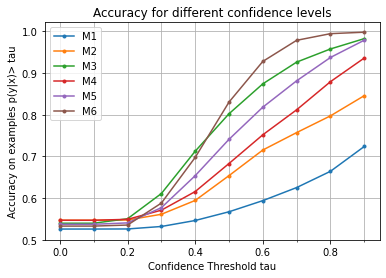

In [229]:
# sns.scatterplot(np.arange(0,1,0.1),accuracy[1])
# plt.plot(np.arange(0,1,0.1),accuracy[0], '.r-') 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.tile(np.arange(0,1,0.1),reps=(len(Ensembles),1)).T, accuracy.T, '.-')
plt.legend(Ensembles)
grid_x_ticks = np.arange(0, 1, 0.1)
grid_y_ticks = np.arange(.5, 1, 0.1)

ax.set_xticks(grid_x_ticks , minor=True)
ax.set_yticks(grid_y_ticks , minor=True)
ax.grid(which='both')
plt.ylabel("Accuracy on examples p(y|x)> τ")
plt.xlabel("Confidence Threshold τ" )
plt.title("Accuracy for different confidence levels")
# plt.savefig(title+'.png', dpi=1000)


In [145]:
above_confidence= np.where(confidence>0.5)[0]
filtered_predictions= prediction[above_confidence]
filtered_labels = label[above_confidence]
binary_accuracy = np.where(filtered_predictions == filtered_labels,1,0)
accuracy = binary_accuracy.sum()/len(binary_accuracy)
len(filtered_predictions),accuracy,binary_accuracy.sum(), len(np.arange(0,1,0.1))

(9687, 0.0, 0, 10)